In [9]:
import numpy as np
from imutils import paths
import imutils
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Image Stitching

#### Loading images

In [14]:
image_paths = sorted(list(paths.list_images('figs/')))
images = list()
# print(image_paths)
for path in image_paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

#### Show loaded images

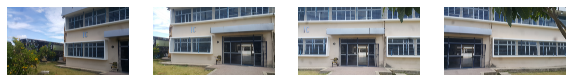

In [16]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 4, 1)
plt.axis('off')
plt.imshow(Image.fromarray(images[0]))
fig.add_subplot(1, 4, 2)
plt.axis('off')
plt.imshow(Image.fromarray(images[1]))
fig.add_subplot(1, 4, 3)
plt.axis('off')
plt.imshow(Image.fromarray(images[2]))
fig.add_subplot(1, 4, 4)
plt.axis('off')
plt.imshow(Image.fromarray(images[3]))

#### Stitching the loaded images

In [17]:
stitcher = cv2.Stitcher_create()
status, stitched = stitcher.stitch(images)

#### Showing the stitching result

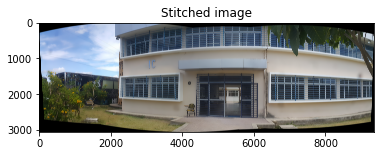

In [18]:
if status == 0:
    plt.title('Stitched image')
    plt.imshow(Image.fromarray(stitched))
else:
    print(f'Image stitching failed. Error: {status}')

#### Masking the image for a more aesthetically pleasing final image

In [20]:
stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))

gray = cv2.cvtColor(stitched, cv2.COLOR_RGB2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

#### Showing the threshold area

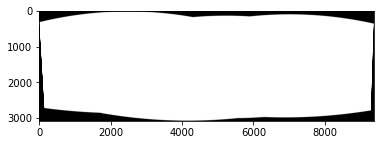

In [22]:
plt.imshow(Image.fromarray(thresh), cmap='gray')

#### Making a border mask

In [23]:
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
c = max(contours, key=cv2.contourArea)

mask = np.zeros(thresh.shape, dtype=np.uint8)
x, y, w, h = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Showing border mask

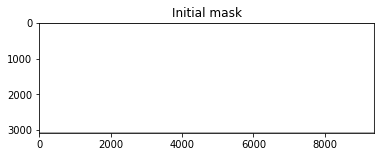

In [24]:
plt.title('Initial mask')
plt.imshow(Image.fromarray(mask), cmap='gray')

#### Adjusting the mask to fit the image

In [25]:
min_rectangle = mask.copy()
sub = mask.copy()

while cv2.countNonZero(sub) > 0:
    min_rectangle = cv2.erode(min_rectangle, None)
    sub = cv2.subtract(min_rectangle, thresh)

#### Find new contours that fit the image

In [26]:
contours = cv2.findContours(min_rectangle.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
c = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(c)

#### Use the new bounding box to extract the final image

In [27]:
stitched = stitched[y:y + h, x:x + w]

#### Final image

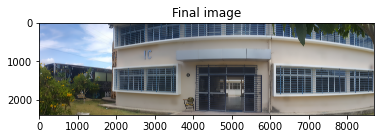

In [28]:
plt.title('Final image')
plt.imshow(Image.fromarray(stitched))

#### Save the final image

In [30]:
Image.fromarray(stitched).save('figs/stitched.png', format='png')